### You have ~57K news articles loaded into:

 - Linux directory on RCC: /project2/msca/kadochnikov/news/news_university.json
 - GCP: gs://msca-bdp-data-open/news/news_university.json

### Your goal is to determine how many of these English articles are unique vs. how many are “near-duplicate”.

In [25]:
#Ensure we are using the right kernel
print (sc.version)

3.0.1


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.cloud import storage

In [4]:
# List all files in given COS directory
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [5]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

In [6]:
# Reading data from open bucket, avaible to all students
bucket_read = 'msca-bdp-data-open'

# Saving results into individual bucket, students must update to their own bucket
bucket_write = 'msca-bdp-students-bucket/shared_data/bharadwajk'

In [7]:
list_blobs(bucket_read,'news')

news/	0
news/News_1.txt	2966
news/news_apple_fruit.json	11352240
news/news_apple_fruit.pkl	10906318
news/news_autos.json	172047077
news/news_chicago_il.json	944211849
news/news_companies.pkl	77077884
news/news_ibm.pkl	46396032
news/news_samsung.json	40934170
news/news_samsung.pkl	38371987
news/news_some_company.json	6363611
news/news_some_company.pkl	6095299
news/news_toyota.json	251980
news/news_toyota.pkl	246220
news/news_university.json	249314366
news/news_university.pkl	139368221


In [8]:
path = "gs://msca-bdp-data-open/news/"

In [9]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [10]:
news_articles = spark.read.json("gs://msca-bdp-data-open/news/news_university.json")
news_articles.count()

57500

In [11]:
news_articles.printSchema()

root
 |-- author: string (nullable = true)
 |-- crawled: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- locations: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- sentiment: string (nullable = true)
 |    |-- organizations: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- sentiment: string (nullable = true)
 |    |-- persons: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- sentiment: string (nullable = true)
 |-- external_links: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- highlightText: string (nullable = true)
 |-- highlightTitle: string (nullable = true)
 |-- language: string (nullable = true)
 |-- ord_in_thread: long (nullable = 

In [12]:
news_articles_raw = news_articles.select(["title"]).withColumnRenamed('title', 'text')

In [13]:
news_articles_raw.limit(5)

text
FREE public plane...
A computer Scienc...
Whos the Greatest...
FULL HD VIDEO || ...
Tips For Newborn ...


In [14]:
news_articles_raw.printSchema()

root
 |-- text: string (nullable = true)



#### Run similarity analysis on the “title” variable  
 - You can use either Jaccard or SimHash (or both to compare the results)  
 - Explain how you selected a similarity threshold for “near-duplicate”  
 - Build a bar-chart visualization for two variables (count of unique and count of “near-duplicate”)  
 - Build a histogram showing the overall distribution of “near-duplication”  

In [15]:
text = news_articles_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [16]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
[FREE public plan...,0
[A computer Scien...,1
[Whos the Greates...,2
[FULL HD VIDEO ||...,3
[Tips For Newborn...,4


In [17]:
df_text.count()

57500

In [18]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[free, public, planetarium, shows, at, wayne, state, university, planetarium, rsvp, 1/26, and, 2/2]",0
1,"[computer, science, professor, at, my, university, sent, this, email, out]",1
2,"[whos, the, greatest, college, football, team, ever]",2
3,"[full, hd, video, ||, ओढ़नी, से, मुह, बाध, के, ||, college, me, aabelu, ||, vivek, dubey, ...]",3
4,"[tips, for, newborn, photography, college, station, tx]",4


In [19]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



##### Countvectorize to create features

In [20]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [21]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[free, public, planetarium, shows, at, wayne, state, university, planetarium, rsvp, 1/26, and, 2/2]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[computer, science, professor, at, my, university, sent, this, email, out]",1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[whos, the, greatest, college, football, team, ever]",2,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[full, hd, video, ||, ओढ़नी, से, मुह, बाध, के, ||, college, me, aabelu, ||, vivek, dubey, ...]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[tips, for, newborn, photography, college, station, tx]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


    Fitting MinHashLSH to create hash table

In [22]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [23]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,[New Headmaster J...,"[new, headmaster,...","(59701,[0,2,4,8,1...","[[6570254.0], [4...."
29,[College track an...,"[college, track, ...","(59701,[0,7,782,2...","[[4.7945584E7], [..."
474,[thirumurugan gan...,"[thirumurugan, ga...","(59701,[0,9,226,2...","[[4.7945584E7], [..."
964,[Edward Waters Co...,"[edward, waters, ...","(59701,[0,198,251...","[[4.7945584E7], [..."
1677,[Community colleg...,"[community, colle...","(59701,[0,37,102,...","[[4.7945584E7], [..."


Evaluating similarity across three levels of similarities, low, medium and high Jaccard distances

In [26]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [ ]:
df_dups_30 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.00,1217,7149,"(University of Kansas group wants school to sell jet,)","(University of Kansas group wants school to sell jet,)"
1,0.00,15652,37597,"(Google Alert - college football,)","(Google Alert - college football,)"
2,0.25,15652,17100,"(Google Alert - college football,)","(Google Alert - college,)"
3,0.00,15799,15861,"(Olympic Scandal Hits Michigan State University; DeVos Calls Students 'Unprepared',)","(Olympic Scandal Hits Michigan State University; DeVos Calls Students 'Unprepared',)"
4,0.25,17393,38561,"(College Basketball Scores,)","(Women’s College Basketball Scores,)"


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  57500
Duplicate titles based on { 0.3 } jaccard distance:  18351
Unique titles based on { 0.3 } jaccard distance:  0.3 :  39149


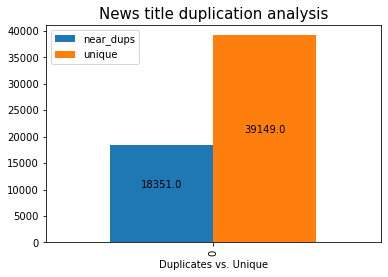

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Medium jaccard distance

In [30]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [31]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.00,2352,3002,"(Google Alert - college,)","(Google Alert - college,)"
1,0.25,2352,46825,"(Google Alert - college,)","(Google Alert - college football,)"
2,0.25,2352,38582,"(Google Alert - college,)","(Google Alert - college football,)"
3,0.25,2352,20291,"(Google Alert - college,)","(Google Alert - college football,)"
4,0.25,2352,39937,"(Google Alert - college,)","(Google Alert - college football,)"


In [32]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  57500
Duplicate titles based on { 0.5 } jaccard distance:  22626
Unique titles based on { 0.5 } jaccard distance:  0.5 :  34874


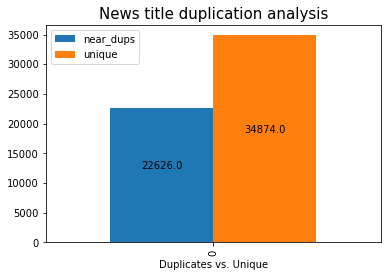

In [33]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### High jaccard distance

In [34]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.25,3397,37469,"(Google Alert - college football,)","(Google Alert - college,)"
1,0.00,3397,13262,"(Google Alert - college football,)","(Google Alert - college football,)"
2,0.25,3397,43509,"(Google Alert - college football,)","(Google Alert - college,)"
3,0.60,3397,25497,"(Google Alert - college football,)","(Google Alert - university,)"
4,0.60,3397,5238,"(Google Alert - college football,)","(Google Alert - university,)"


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  57500
Duplicate titles based on { 0.7 } jaccard distance:  35454
Unique titles based on { 0.7 } jaccard distance:  0.7 :  22046


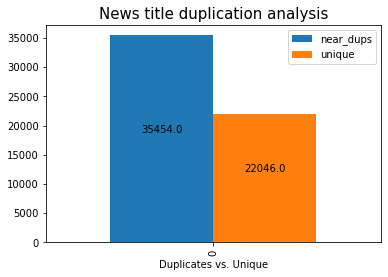

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
#### Comparing all the thresholds

In [ ]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

542035
607587
1239013


In [ ]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

text_A,text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
[Google Alert - c...,[Google Alert - c...,3929,26976,3929,26976,3929,26976
[Google Alert - c...,[Google Alert - c...,15652,20344,15652,20344,15652,20344
[COLLEGE BASKETBA...,[College Basketba...,1551,19600,null,null,null,null
[Embattled Missou...,[Gov. Greitens' b...,2453,2691,null,null,null,null
[College Basketba...,[Friday's College...,8600,36834,null,null,null,null


#### Creating a duplicate vs non-duplicate flag for each similarity

In [ ]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5)

text_A,text_B,threshold_30,threshold_50,threshold_70
[Oregon State vs....,[Oregon State vs....,Duplicate,Duplicate,Duplicate
[Google Alert - c...,[Google Alert - c...,Duplicate,Duplicate,Duplicate
[Google Alert - c...,[Google Alert - u...,Non-Dup,Non-Dup,Duplicate
[Google Alert - c...,[Google Alert - c...,Duplicate,Duplicate,Duplicate
[Google Alert - c...,[Google Alert - u...,Non-Dup,Non-Dup,Duplicate


##### Select a sample of records across 3 thresholds (jaccard similarities):
* Records that are marked as duplicate by all three thresholds (meet the level of **threshold_30**)
* Records that are identified as non-duplicate by **threshold_30**, while being marked as dups by both **threshold_50** and **threshold_70**
* Records that are identified as non-duplicate by both **threshold_30** and **threshold_50**, while being marked as dups by **threshold_70**

In [ ]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [ ]:
pd.set_option('display.max_rows', 30)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"(Google Alert - college,)","(Google Alert - college,)",Duplicate,Duplicate,Duplicate
1,"(Google Alert - college football,)","(Google Alert - college football,)",Duplicate,Duplicate,Duplicate
2,"(Google Alert - college football,)","(Google Alert - college football,)",Duplicate,Duplicate,Duplicate
3,"(Google Alert - college,)","(Google Alert - college football,)",Duplicate,Duplicate,Duplicate
4,"(Google Alert - university,)","(Google Alert - university,)",Duplicate,Duplicate,Duplicate
5,"(Utah State University student hospitalized after eating Tide Pod,)","(Utah State University student hospitalized after eating Tide Pod,)",Duplicate,Duplicate,Duplicate
6,"(Google Alert - university,)","(Google Alert - university,)",Duplicate,Duplicate,Duplicate
7,"(Google Alert - college football,)","(Google Alert - college football,)",Duplicate,Duplicate,Duplicate
8,"(Google Alert - university,)","(Google Alert - university,)",Duplicate,Duplicate,Duplicate
9,"(Google Alert - university,)","(Google Alert - university,)",Duplicate,Duplicate,Duplicate


We can see some sample titles which are **marked as duplicate or non-duplicate by all the thresholds**.

The **first 10** titles, which are marked as "**duplicate**" by all the thresholds, they seem pretty similar. So **all** Jaccard distance thresholds of **0.3,0.5,0.7** seem to do **good work** for these titles.

These are followed by the **next 10** titles (**index 10 to 19**), we can observe that they are marked as "**non-duplicate**" for **0.3** threshold, but are marked "**duplicate**" for **0.5** and **0.7** thresholds. On further observation we can see that the titles have been incorrectly classified as duplicate for both **0.5 and 0.7 thresholds** 

For **last 10** titles (**index 20 to 29**), we see that they are marked as "**non-duplicate**" by the **0.3** threshold and **0.5** thresholds, but are classified as "**duplicate**" by **0.7** threshold. On further observation of the titles we can see that most of the titles are **non-duplicates**. So, the thresholds **0.3** and **0.5** correctly classify the records as non-duplicates.

Jaccard distance of **0.3** does a very good job for classifiying near-similar duplicates.

### Using Simhash to find near duplicates

In [5]:
# basic imports
import pandas as pd
import re
import json
from itertools import combinations, takewhile
import collections
!pip install simhash 
from simhash import Simhash, SimhashIndex
import matplotlib.pyplot as plt

In [6]:
# defining the function to get features
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

In [7]:
# reading the json file
news_df = pd.read_json('gs://msca-bdp-data-open/news/news_university.json', orient='records', lines=True)
news_df.shape

(57500, 15)

In [8]:
# extracting only the tiltes
news_df = news_df[['title']]

In [9]:
# checking first few records
pd.set_option('max_colwidth',100)    
news_df.head(5)

,title
0,FREE public planetarium shows at Wayne State University Planetarium - RSVP 1/26 and 2/2
1,A computer Science professor at my university sent this email out
2,Whos the Greatest College Football Team Ever
3,FULL HD VIDEO || ओढ़नी से मुह बाध के || College Me Aabelu || Vivek Dubey ...
4,Tips For Newborn Photography College Station TX


In [10]:
# converting to dictionary so that we have an id for each title
data = news_df['title'].to_dict()

In [11]:
# checking first few values
data_first = {k: data[k] for k in list(data)[:5]}
data_first

{0: 'FREE public planetarium shows at Wayne State University Planetarium - RSVP 1/26 and 2/2',
 1: 'A computer Science professor at my university sent this email out',
 2: 'Whos the Greatest College Football Team Ever',
 3: 'FULL HD VIDEO || ओढ़नी से मुह बाध के || College Me Aabelu || Vivek Dubey ...',
 4: 'Tips For Newborn Photography College Station TX'}

In [12]:
# using simhash to find bucket size
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index_k3 = SimhashIndex(objs, k=3)
print (index_k3.bucket_size())

88632


In [13]:
s1 = Simhash(get_features(u"Google Alert - university,"))
s1_dups = index_k3.get_near_dups(s1)
print (index_k3.get_near_dups(s1))
print(len(index_k3.get_near_dups(s1)))

Big bucket found. key:9c13:0, len:385
Big bucket found. key:8360:1, len:384
Big bucket found. key:6d78:2, len:391
Big bucket found. key:7134:3, len:386
Big bucket found. key:9c13:0, len:385
Big bucket found. key:8360:1, len:384
Big bucket found. key:6d78:2, len:391
Big bucket found. key:7134:3, len:386
Big bucket found. key:9c13:0, len:385
Big bucket found. key:8360:1, len:384
Big bucket found. key:6d78:2, len:391
Big bucket found. key:7134:3, len:386


['43658', '10485', '7350', '29061', '39007', '20349', '24745', '57136', '20637', '16244', '14225', '18639', '43156', '15601', '52456', '29465', '4238', '18212', '32473', '24408', '47001', '3248', '18148', '29639', '55923', '9223', '46881', '32593', '29168', '30363', '33277', '39502', '8634', '6811', '17218', '30588', '11139', '3458', '51460', '6420', '22876', '39257', '41055', '29553', '21131', '3249', '1364', '26984', '7488', '14938', '26229', '45140', '12635', '6682', '35984', '34696', '18807', '40975', '48568', '21926', '12292', '36826', '27080', '54390', '24900', '3075', '18544', '47376', '50384', '25764', '16475', '9423', '39970', '38534', '31471', '19205', '25497', '31921', '37182', '42623', '39743', '38240', '56655', '17594', '10601', '16024', '38165', '18016', '39006', '388', '9325', '52099', '13174', '36522', '37739', '17797', '45849', '39649', '46121', '2241', '45403', '5150', '40074', '20982', '40900', '47098', '18724', '50679', '40315', '39339', '7760', '55723', '38859', '3

In [14]:
s2 = Simhash(get_features(u"Oregon college safety officer pleads guilty to killing woman"))
s2_dups = index_k3.get_near_dups(s2)
print (index_k3.get_near_dups(s2))
print(len(index_k3.get_near_dups(s2)))

['1685', '5007', '1560', '7662', '2171', '1769', '1895', '1708', '1612', '1897', '1730', '1808', '1705', '1727', '3489', '1658', '1704', '1561', '5006', '1616', '1641', '1945', '1802', '1950']
24


In [15]:
# checking the titles
news_df.iloc[s2_dups]

,title
1685,Oregon college safety officer pleads guilty to killing woman
5007,Oregon college safety officer pleads guilty to killing woman
1560,Oregon college safety officer pleads guilty to killing woman
7662,Oregon college safety officer pleads guilty to killing woman
2171,Oregon college safety officer pleads guilty to killing woman
1769,Oregon college safety officer pleads guilty to killing woman
1895,Oregon college safety officer pleads guilty to killing woman
1708,Oregon college safety officer pleads guilty to killing woman
1612,Oregon college safety officer pleads guilty to killing woman
1897,Oregon college safety officer pleads guilty to killing woman


In [23]:
# k = 1
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index_k1 = SimhashIndex(objs, k=1)

print (index_k1.bucket_size())

86934


In [24]:
s2 = Simhash(get_features(u"Oregon college safety officer pleads guilty to killing woman"))
s2_dups = index_k1.get_near_dups(s2)
print (index_k1.get_near_dups(s2))
print(len(index_k1.get_near_dups(s2)))

['1685', '5007', '1560', '7662', '2171', '1769', '1895', '1708', '1612', '1897', '1730', '1808', '1705', '1727', '3489', '1658', '1704', '1561', '5006', '1616', '1641', '1945', '1802', '1950']
24


**k = 1** did not create a difference to the bucket size of this title.

Let's try **k = 10**

In [16]:
# k = 10
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index_k10 = SimhashIndex(objs, k=10)

print (index_k10.bucket_size())

12343


In [17]:
s2 = Simhash(get_features(u"Oregon college safety officer pleads guilty to killing woman"))
s2_dups = index_k10.get_near_dups(s2)
print (index_k10.get_near_dups(s2))
print(len(index_k10.get_near_dups(s2)))

Big bucket found. key:c:0, len:1304
Big bucket found. key:11:1, len:1383
Big bucket found. key:14:2, len:592
Big bucket found. key:15:3, len:2670
Big bucket found. key:1c:4, len:5835
Big bucket found. key:4:5, len:3390
Big bucket found. key:8:6, len:1485
Big bucket found. key:1c:7, len:1625
Big bucket found. key:8:8, len:5230
Big bucket found. key:9:9, len:1576
Big bucket found. key:c:0, len:1304
Big bucket found. key:11:1, len:1383
Big bucket found. key:14:2, len:592
Big bucket found. key:15:3, len:2670
Big bucket found. key:1c:4, len:5835
Big bucket found. key:4:5, len:3390
Big bucket found. key:8:6, len:1485
Big bucket found. key:1c:7, len:1625
Big bucket found. key:8:8, len:5230
Big bucket found. key:9:9, len:1576
Big bucket found. key:c:0, len:1304
Big bucket found. key:11:1, len:1383
Big bucket found. key:14:2, len:592
Big bucket found. key:15:3, len:2670
Big bucket found. key:1c:4, len:5835
Big bucket found. key:4:5, len:3390
Big bucket found. key:8:6, len:1485
Big bucket found.

['1685', '5007', '1560', '3885', '2171', '7662', '1895', '1769', '1708', '1612', '1897', '1730', '1808', '1705', '1727', '3489', '1658', '1704', '1561', '5006', '1616', '1799', '1572', '1641', '1945', '1802', '1950']


Big bucket found. key:9:9, len:1576


27


tolerance level of 10 has **increased** the bucket size.

Here are the similar titles

In [18]:
news_df.iloc[s2_dups]

,title
1685,Oregon college safety officer pleads guilty to killing woman
5007,Oregon college safety officer pleads guilty to killing woman
1560,Oregon college safety officer pleads guilty to killing woman
3885,Oregon college safety officer pleads guilty to killing woman - SFGate
2171,Oregon college safety officer pleads guilty to killing woman
7662,Oregon college safety officer pleads guilty to killing woman
1895,Oregon college safety officer pleads guilty to killing woman
1769,Oregon college safety officer pleads guilty to killing woman
1708,Oregon college safety officer pleads guilty to killing woman
1612,Oregon college safety officer pleads guilty to killing woman


Tolerance level of **k = 3 is ideal**, because it identifies the dupicates properly.

Looping over **all the titles** with k = 3

In [19]:
bucket_sizes = list()
for k,v in data.items():
    s = Simhash(get_features(v))
    s_dups = index_k3.get_near_dups(s)
    if(len(index_k3.get_near_dups(s))>1):
        bucket_sizes.append(len(index_k3.get_near_dups(s)))

Big bucket found. key:cc32:0, len:377
Big bucket found. key:4142:1, len:388
Big bucket found. key:49b4:2, len:391
Big bucket found. key:3310:3, len:377
Big bucket found. key:cc32:0, len:377
Big bucket found. key:4142:1, len:388
Big bucket found. key:49b4:2, len:391
Big bucket found. key:3310:3, len:377
Big bucket found. key:cc32:0, len:377
Big bucket found. key:4142:1, len:388
Big bucket found. key:49b4:2, len:391
Big bucket found. key:3310:3, len:377
Big bucket found. key:8472:0, len:388
Big bucket found. key:4140:1, len:392
Big bucket found. key:6c34:2, len:388
Big bucket found. key:3d32:3, len:397
Big bucket found. key:8472:0, len:388
Big bucket found. key:4140:1, len:392
Big bucket found. key:6c34:2, len:388
Big bucket found. key:3d32:3, len:397
Big bucket found. key:8472:0, len:388
Big bucket found. key:4140:1, len:392
Big bucket found. key:6c34:2, len:388
Big bucket found. key:3d32:3, len:397
Big bucket found. key:9c13:0, len:385
Big bucket found. key:8360:1, len:384
Big bucket f

In [20]:
# number of buckets we got
len(bucket_sizes)

19605

**Visualizing the bucket sizes**

Text(0.5, 0, 'Bucket Sizes')

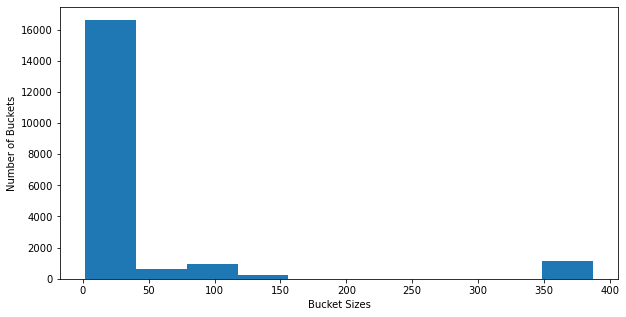

In [21]:
plt.figure(figsize=(10,5))
plt.hist(bucket_sizes,bins=10)
plt.ylabel('Number of Buckets')
plt.xlabel('Bucket Sizes')

We see that most of the buckets have a size between **2 and 50**. There are some buckets with sizes which are around **100 and 150**. There are also many buckets whose sizes are between **350 and 400**.